
In this notebook supervised learning techniques are used to classify spectra for stars. Spectra are very detailed colors. Instead of 3 colors like in RGB they can have much more. In our case they are 3072 in the raw data. Like images they have numeric values. Here they are floats, thus the features are a vector 3072 floats. The spectra are normalized by fitting a linear function to a range which is does not have strong features. 

In [73]:
#basic libraries
import numpy as np

import pandas as pd
import scipy as sp

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns


#We mainly use xgboost
from xgboost import XGBClassifier
import xgboost as xgb

#some skitlearn tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

#logistic regression
from sklearn.linear_model import LogisticRegression

#Keras Neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding

#Astrop.io is needed to read the files with the astronomical features. 
from astropy.io import fits

Below we load the feature and label data.

In [2]:
#directory of the data
path='/home/tobias/ml-testing/spectra-ML/met-cal-22/'
#feature data
x=np.loadtxt(path+'feature_classification.txt')
print(f"shape of feature data is {np.shape(x)}")
print(f"There are {np.shape(x)[1]} examples with each {np.shape(x)[0]} features")
#includes besides main labels also other data
yplus=np.loadtxt(path+'label_classification.txt')
print(f"shape of label data is {np.shape(yplus)}")
#there are three labels values
print(f"number of 0 labels {np.count_nonzero(yplus[0,:]==0)}")
print(f"number of 1 labels {np.count_nonzero(yplus[0,:]==1)}")
print(f"number of 2 labels {np.count_nonzero(yplus[0,:]==2)}")

shape of feature data is (3072, 3773)
There are 3773 examples with each 3072 features
shape of label data is (5, 3773)
number of 0 labels 57
number of 1 labels 3661
number of 2 labels 55


There are three exclusive labels. 1 and 2 describe different recognisable classes. 0 is for all for which the class cannot be identified.  We now look on the features to exclude some of them. 

(3072, 1, 57)


Text(0, 0.5, 'feature value')

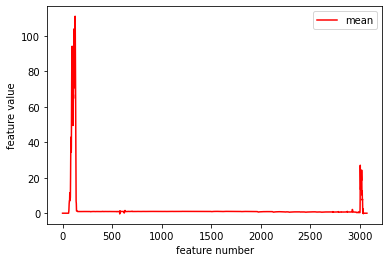

In [3]:
#separate class for statistic
class0=x[:,np.where(yplus[0,:]==0)]
class1=x[:,np.where(yplus[0,:]==1)]
class2=x[:,np.where(yplus[0,:]==2)]
print(np.shape(class0))
res=np.zeros((15,3072))
cg=np.shape(x)[1]
for i in range(3072):
    res[0,i]=i
    res[1,i]= np.count_nonzero(x[i]==0)/cg
    res[2,i]=1.92499995231628+i*0.000187174489838071  #wavelength in micron the physical meaning of the labels 
    res[3,i]=np.mean(x[i]) #statistic of all
    res[4,i]=np.median(x[i])    
    res[5,i]=np.std(x[i])  
    res[6,i]=np.mean(class0[i]) #statistic of class0
    res[7,i]=np.median(class0[i])    
    res[8,i]=np.std(class0[i])    
    res[9,i]=np.mean(class1[i]) #statistic of class0
    res[10,i]=np.median(class1[i])    
    res[11,i]=np.std(class1[i])
    res[12,i]=np.mean(class2[i]) #statistic of class0
    res[13,i]=np.median(class2[i])    
    res[14,i]=np.std(class2[i])     
plt.plot(res[0],res[3],'-',color='red',label='mean') 
plt.legend(loc="best")
#plt.xlim(1.95,2.48)
#plt.ylim(0.3,1.4)
plt.xlabel("feature number")
plt.ylabel("feature value")

Some of most extreme values have strong peaks partly. WE now zoom in them. 

Text(0, 0.5, 'feature value')

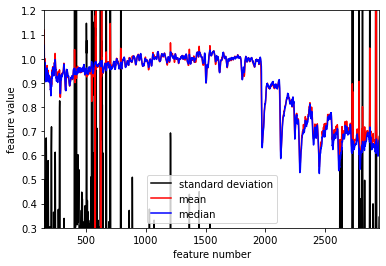

In [4]:
plt.plot(res[0],res[5],'-',color='black',label='standard deviation') 
plt.plot(res[0],res[3],'-',color='red',label='mean') 
plt.plot(res[0],res[4],'-',color='blue',label='median') 
plt.legend(loc="best")
plt.xlim(150,2950)
plt.ylim(0.3,1.2)
plt.xlabel("feature number")
plt.ylabel("feature value")

Text(0, 0.5, 'standard deviation')

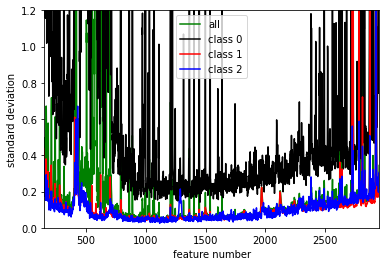

In [5]:
plt.plot(res[0],res[5],'-',color='green',label='all') 
plt.plot(res[0],res[8],'-',color='black',label='class 0') 
plt.plot(res[0],res[11],'-',color='red',label='class 1') 
plt.plot(res[0],res[14],'-',color='blue',label='class 2') 
plt.legend(loc="best")
plt.xlim(150,2950)
plt.ylim(0.0,1.2)
plt.xlabel("feature number")
plt.ylabel("standard deviation")

Text(0, 0.5, 'median')

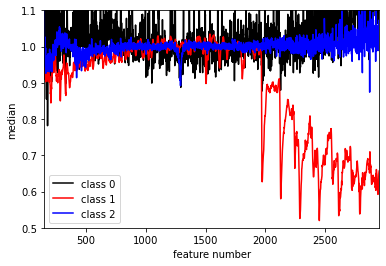

In [6]:
plt.plot(res[0],res[7],'-',color='black',label='class 0') 
plt.plot(res[0],res[10],'-',color='red',label='class 1') 
plt.plot(res[0],res[13],'-',color='blue',label='class 2') 
plt.legend(loc="best")
plt.xlim(150,2950)
plt.ylim(0.5,1.1)
plt.xlabel("feature number")
plt.ylabel("median")

For the analysis we avoid the feature ranges with string spikes. We select between 800 and 2700.

In [7]:
low=800
high=2700
#features
xsel=x[low:high]
#statistic
ressel=res[:,low:high] 
# some visulazation would be good best by type heatmap does not work too slow 
#sns.heatmap(xsel, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('features'),plt.xlabel('feature number'),plt.ylabel('example number');

Classes in the selected range. 

Text(0, 0.5, 'average')

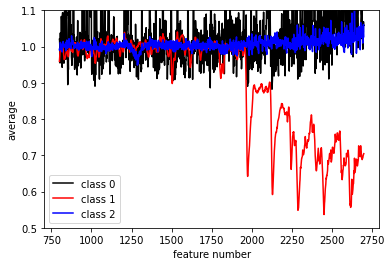

In [8]:
plt.plot(ressel[0],ressel[6],'-',color='black',label='class 0') 
plt.plot(ressel[0],ressel[9],'-',color='red',label='class 1') 
plt.plot(ressel[0],ressel[12],'-',color='blue',label='class 2') 
plt.legend(loc="best")
plt.ylim(0.5,1.1)
plt.xlabel("feature number")
plt.ylabel("average")

There are no very narrow positive spikes visible in class 1 and 2. Class 0 has some as expected, since it consists of not so good data.

A relative large test set is used because not many sources are in the rare classes.

In [9]:
xsel_train, xsel_test, y_train, y_test, yplus_train,yplus_test= train_test_split(np.transpose(xsel), yplus[0], yplus.T, test_size=0.3, random_state=42)
print(f"shape of training features {np.shape(xsel_train)}")
print(f"shape of training labels {np.shape(y_train)}")

shape of training features (2641, 1900)
shape of training labels (2641,)


We start with logistic regression.

In [10]:
lr1 = LogisticRegression('none',max_iter=200)
lr1.fit(xsel_train,y_train)

LogisticRegression(max_iter=200, penalty='none')

In [11]:
restr=lr1.predict_proba(xsel_train)  #probabilities
reste=lr1.predict_proba(xsel_test)
restrc=lr1.predict(xsel_train)  #classes
restec=lr1.predict(xsel_test)


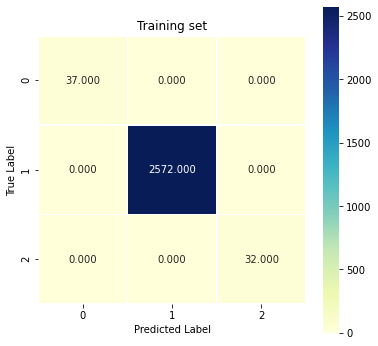

In [12]:
cm_nbtrain = confusion_matrix(y_train, restrc)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrain, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

As visisble in the confusion matrix, the model predicts the labels perfectly for the training label. In contrast 
in the test case there are a number of miss classified sources. Thus there is overfitting. 

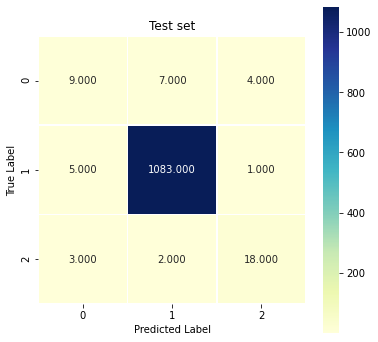

In [13]:
cm_nbtest = confusion_matrix(y_test, restec)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtest, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

To be quantitaive in decding how good the model is we use the F1 measure of each class. We use class separatly because
as expected the rare classes seem more difficult. 

In [14]:
#gets f1 score for a specified  from confusing matrix 
def fmeas(conf_matrix,x):
    if np.sum(conf_matrix[:,x])==0:
        prec=0
    else:
        prec=conf_matrix[x,x]/np.sum(conf_matrix[:,x])
    if np.sum(conf_matrix[x])==0:
        rec=0
    else:
        rec=conf_matrix[x,x]/np.sum(conf_matrix[x])

    if prec==0 and rec==0:
        f1=0
    else:
        prec=conf_matrix[x,x]/np.sum(conf_matrix[:,x])
        rec=conf_matrix[x,x]/np.sum(conf_matrix[x])
        f1=(2*prec*rec)/(prec+rec)
    return f1

In [15]:
print(f"F1 score (test, class 0) {round(fmeas(cm_nbtest,0),3)}")
print(f"F1 score (test, class 1) {round(fmeas(cm_nbtest,1),3)}")
print(f"F1 score (test, class 2) {round(fmeas(cm_nbtest,2),3)}")

F1 score (test, class 0) 0.486
F1 score (test, class 1) 0.993
F1 score (test, class 2) 0.783


The F1 is worth for class 2 and even worse for class 0. That class 0 is most difficult is to be expected, because it is a left over class.

To reduce overfitting, we now add regularization. We explore a range of regularzations parameters.


In [16]:
#regularzaition in steps of factor 2
regs=np.zeros((7,13))
regs[0,0]=1
regs[0,1]=0.5
regs[0,2]=0.22
regs[0,3]=0.1
regs[0,4]=0.05
regs[0,5]=0.022
regs[0,6]=0.01
regs[0,7]=0.005
regs[0,8]=0.0022
regs[0,9]=0.001
regs[0,10]=0.0005
regs[0,11]=0.00022
regs[0,12]=0.0001
for i in range(np.shape(regs)[1]):
    print(f"regulurization {regs[0,i]}")
    lr3 = LogisticRegression('l2',max_iter=1500,C=regs[0,i])
    lr3.fit(xsel_train,y_train)
    restrc3=lr3.predict(xsel_train)  
    restec3=lr3.predict(xsel_test)
    cm_nbtest3 = confusion_matrix(y_test, restec3)
    cm_nbtrain3 = confusion_matrix(y_train, restrc3)  
    regs[1,i]=fmeas(cm_nbtest3,0)
    regs[2,i]=fmeas(cm_nbtest3,2)
    regs[3,i]=np.mean(regs[1:3,i])
    regs[4,i]=fmeas(cm_nbtrain3,0)
    regs[5,i]=fmeas(cm_nbtrain3,2)
    regs[6,i]=np.mean(regs[4:6,i])  

regulurization 1.0
regulurization 0.5
regulurization 0.22
regulurization 0.1
regulurization 0.05
regulurization 0.022
regulurization 0.01
regulurization 0.005
regulurization 0.0022
regulurization 0.001
regulurization 0.0005
regulurization 0.00022
regulurization 0.0001


F1 score (test, class 0) no regulurization 0.486
F1 score (test, class 2) no regulurization 0.783
F1 score (test, class 0) best regulurization 0.5
F1 score (test, class 2) best regulurization 0.836


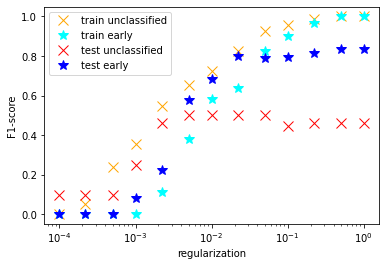

In [17]:
plt.plot(regs[0],regs[4],'x',color='orange',ms=10,label='train unclassified') 
plt.plot(regs[0],regs[5],'*',color='cyan',ms=10,label='train early') 
plt.plot(regs[0],regs[1],'x',color='red',ms=10,label='test unclassified') 
plt.plot(regs[0],regs[2],'*',color='blue',ms=10,label='test early') 
plt.legend(loc="best")
plt.xlabel("regularization")
plt.xscale("log")
plt.ylabel("F1-score")
print(f"F1 score (test, class 0) no regulurization {round(fmeas(cm_nbtest,0),3)}")
print(f"F1 score (test, class 2) no regulurization {round(fmeas(cm_nbtest,2),3)}")
print(f"F1 score (test, class 0) best regulurization {round(max(regs[1]),3)}")
print(f"F1 score (test, class 2) best regulurization {round(max(regs[2]),3)}")

Regularization improves only a little for test, the best F1 score a very similar to the F1 score with no regularization. 

Intrinsic noisy (random variation between neighboring features) clearly affects the data. It is a main reason for unclassified classifications. Logistic regression has likely difficult to recognize that because the sample of unclassfied is too small that it can recognize it from the data. Th measure of is the signal to onise. The signal to noise is calculated standard deviation between the features and the features smoothed with a Gaussian of a width of 1 pixel over the wavelength range between 2.08 and 2.29 were the features are normalized.
We use its inverse the noise level here, to make it more important when the signal is low.
This feature is brought on the a similar level as the other features, by scaling the mean in the training samples to one. 

In [39]:
#the noise lvel is feature is currently in the general labels at 7
print(f"s/n is {yplus[4]}")
#add noise to new feature vector
print(f"current feature shape of traing set is {np.shape(xsel_train)}")
#create new features
xsel_train2=np.zeros((np.shape(xsel_train)[0],np.shape(xsel_train)[1]+1))
xsel_test2=np.zeros((np.shape(xsel_test)[0],np.shape(xsel_test)[1]+1))
#copy old 
xsel_train2[:,0:np.shape(xsel_train)[1]]=xsel_train
xsel_test2[:,0:np.shape(xsel_test)[1]]=xsel_test
#add noise level as feature it
xsel_train2[:,np.shape(xsel_train)[1]]=1/yplus_train[:,4]/np.mean(1/yplus_train[:,4])
xsel_test2[:,np.shape(xsel_test)[1]]=1/yplus_test[:,4]/np.mean(1/yplus_train[:,4])
print(f"mean of noise feature is {np.mean(xsel_train2[:,np.shape(xsel_train)[1]])}")

s/n is [ 54.56041175  58.37582071  49.42498075 ...  51.15859649  93.74415085
 146.37331923]
current feature shape of traing set is (2641, 1900)
mean of noise feature is 1.0


We repeat now the regularized logistic regression but now with the noise level as additional feature.

In [43]:
#regularzaition in steps of factor 2
regs2=np.zeros((7,16))
regs2[0,0]=10
regs2[0,1]=5
regs2[0,2]=2.2
regs2[0,3]=1
regs2[0,4]=0.5
regs2[0,5]=0.22
regs2[0,6]=0.1
regs2[0,7]=0.05
regs2[0,8]=0.022
regs2[0,9]=0.01
regs2[0,10]=0.005
regs2[0,11]=0.0022
regs2[0,12]=0.001
regs2[0,13]=0.0005
regs2[0,14]=0.00022
regs2[0,15]=0.0001
for i in range(np.shape(regs2)[1]):
    print(f"regulurization {regs2[0,i]}")
    lr3 = LogisticRegression('l2',max_iter=1500,C=regs2[0,i])
    lr3.fit(xsel_train2,y_train)
    restrc3=lr3.predict(xsel_train2)  
    restec3=lr3.predict(xsel_test2)
    cm_nbtest3 = confusion_matrix(y_test, restec3)
    cm_nbtrain3 = confusion_matrix(y_train, restrc3)  
    regs2[1,i]=fmeas(cm_nbtest3,0)
    regs2[2,i]=fmeas(cm_nbtest3,2)
    regs2[3,i]=np.mean(regs2[1:3,i])
    regs2[4,i]=fmeas(cm_nbtrain3,0)
    regs2[5,i]=fmeas(cm_nbtrain3,2)
    regs2[6,i]=np.mean(regs2[4:6,i])  

regulurization 10.0
regulurization 5.0
regulurization 2.2
regulurization 1.0
regulurization 0.5
regulurization 0.22
regulurization 0.1
regulurization 0.05
regulurization 0.022
regulurization 0.01
regulurization 0.005
regulurization 0.0022
regulurization 0.001
regulurization 0.0005
regulurization 0.00022
regulurization 0.0001


F1 score (test, class 0) no regulurization 0.486
F1 score (test, class 2) no regulurization 0.783
F1 score (test, class 0) best regulurization 0.5
F1 score (test, class 2) best regulurization 0.836
F1 score (test, class 0) best regulurization with noise 0.788
F1 score (test, class 2) best regulurization with noise 0.92


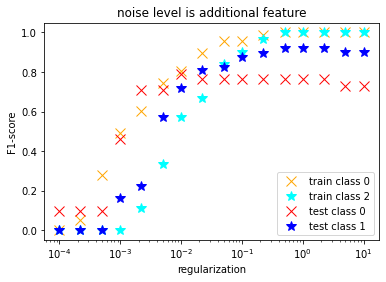

In [44]:
plt.plot(regs2[0],regs2[4],'x',color='orange',ms=10,label='train class 0') 
plt.plot(regs2[0],regs2[5],'*',color='cyan',ms=10,label='train class 2') 
plt.plot(regs2[0],regs2[1],'x',color='red',ms=10,label='test class 0') 
plt.plot(regs2[0],regs2[2],'*',color='blue',ms=10,label='test class 1') 
plt.legend(loc="best")
plt.xlabel("regularization")
plt.xscale("log")
plt.ylabel("F1-score")
plt.title("noise level is additional feature")
print(f"F1 score (test, class 0) no regulurization {round(fmeas(cm_nbtest,0),3)}")
print(f"F1 score (test, class 2) no regulurization {round(fmeas(cm_nbtest,2),3)}")
print(f"F1 score (test, class 0) best regulurization {round(max(regs[1]),3)}")
print(f"F1 score (test, class 2) best regulurization {round(max(regs[2]),3)}")
print(f"F1 score (test, class 0) best regulurization with noise {round(max(regs2[1]),3)}")
print(f"F1 score (test, class 2) best regulurization with noise {round(max(regs2[2]),3)}")

Adding the noise as additional parameter has clearly imporved the classification performance. As before there is overfitting with large C since it performs better on the traing set but the overfitting does not seem to impact the performance on the test sample much. The clasification of class 0 peaks for  C~0.01 while the earky clasfication improves until about 1 by a larger amount. That behaviour is to be expected, because in the absent of many common properties of class 0 less are needed to recognise it as well as possible in the rather small sample. 

We now look closer on the problems in classification. For that we run it again with  C of 1.

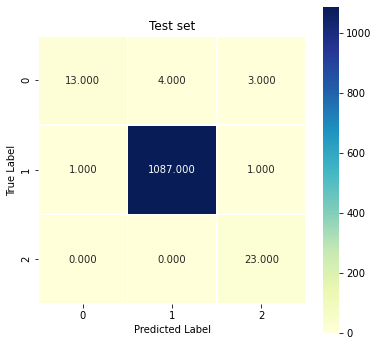

In [80]:
lr3 = LogisticRegression('l2',max_iter=1500,C=1)
lr3.fit(xsel_train2,y_train)
restrc3=lr3.predict(xsel_train2)  
restec3=lr3.predict(xsel_test2)
restrp3=lr3.predict_proba(xsel_train2)  
restep3=lr3.predict_proba(xsel_test2)
cm_nbtest3 = confusion_matrix(y_test, restec3)
cm_nbtrain3 = confusion_matrix(y_train, restrc3)  
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtest3, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

As visible in the confusion matrix the main problem is that class 0 cases are classfied as other classes. 

(1, 4, 1900)


Text(0, 0.5, 'average')

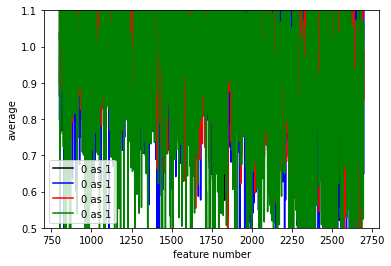

In [69]:
class0as1=xsel_test[np.where((y_test==0) & (restec3==1)),:]
class0as2=xsel_test[np.where((y_test==0) & (restec3==2)),:]
class1as0=xsel_test[np.where((y_test==1) & (restec3==0)),:]
class1as2=xsel_test[np.where((y_test==1) & (restec3==2)),:]
print(np.shape(class0as1))
plt.plot(ressel[0],class0as1[0,0,:],'-',color='black',label='0 as 1') 
plt.plot(ressel[0],class0as1[0,1,:],'-',color='blue',label='0 as 1') 
plt.plot(ressel[0],class0as1[0,2,:],'-',color='red',label='0 as 1') 
plt.plot(ressel[0],class0as1[0,3,:],'-',color='green',label='0 as 1') 
plt.legend(loc="best")
plt.ylim(0.5,1.1)
plt.xlabel("feature number")
plt.ylabel("average")
#noisy but yes curvature is osisble sign forn late 

Text(0, 0.5, 'average')

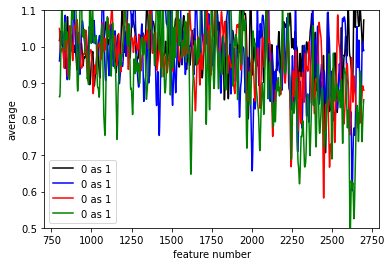

In [75]:
plt.plot(ressel[0],sp.ndimage.gaussian_filter(class0as1[0,0,:],4),'-',color='black',label='0 as 1') 
plt.plot(ressel[0],sp.ndimage.gaussian_filter(class0as1[0,1,:],4),'-',color='blue',label='0 as 1') 
plt.plot(ressel[0],sp.ndimage.gaussian_filter(class0as1[0,2,:],4),'-',color='red',label='0 as 1') 
plt.plot(ressel[0],sp.ndimage.gaussian_filter(class0as1[0,3,:],4),'-',color='green',label='0 as 1') 
plt.legend(loc="best")
plt.ylim(0.5,1.1)
plt.xlabel("feature number")
plt.ylabel("average")

Text(0, 0.5, 'average')

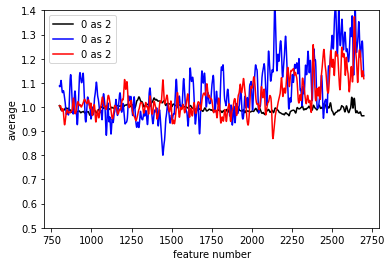

In [77]:
plt.plot(ressel[0],sp.ndimage.gaussian_filter(class0as2[0,0,:],4),'-',color='black',label='0 as 2') 
plt.plot(ressel[0],sp.ndimage.gaussian_filter(class0as2[0,1,:],4),'-',color='blue',label='0 as 2') 
plt.plot(ressel[0],sp.ndimage.gaussian_filter(class0as2[0,2,:],4),'-',color='red',label='0 as 2') 
plt.legend(loc="best")
plt.ylim(0.5,1.4)
plt.xlabel("feature value")
plt.ylabel("average")

Text(0, 0.5, 'average')

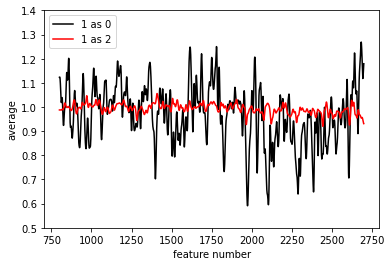

In [79]:
plt.plot(ressel[0],sp.ndimage.gaussian_filter(class1as0[0,0,:],4),'-',color='black',label='1 as 0') 
plt.plot(ressel[0],sp.ndimage.gaussian_filter(class1as2[0,0,:],4),'-',color='red',label='1 as 2') 
plt.legend(loc="best")
plt.ylim(0.5,1.4)
plt.xlabel("feature number")
plt.ylabel("feature value")

We compare the probabilities now. 

In [84]:
for i in range(np.shape(restec3)[0]):
    if restec3[i]!=y_test[i]:
        print(f"real class {round(y_test[i])} has probabilities {restep3[i]}")

real class 0 has probabilities [0.00979416 0.10216744 0.8880384 ]
real class 1 has probabilities [0.01760687 0.21771924 0.76467389]
real class 0 has probabilities [0.08749207 0.67432071 0.23818722]
real class 0 has probabilities [0.15897467 0.83137656 0.00964877]
real class 1 has probabilities [0.84335923 0.1546338  0.00200697]
real class 0 has probabilities [4.50614156e-03 9.94980759e-01 5.13099249e-04]
real class 0 has probabilities [0.05501647 0.00263964 0.94234389]
real class 0 has probabilities [1.39518672e-01 8.60106277e-01 3.75051417e-04]
real class 0 has probabilities [0.20493344 0.08334896 0.7117176 ]


We are now usingthe XGBoost classifier with standard settings.

In [18]:
modelx1 = XGBClassifier()
modelx1.fit(xsel_train, y_train)

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:21:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

Getting the predictions of test and training.

In [19]:
y_pred_train = modelx1.predict(xsel_train)
y_pred_test = modelx1.predict(xsel_test)


We look again on the confusion matrixes.

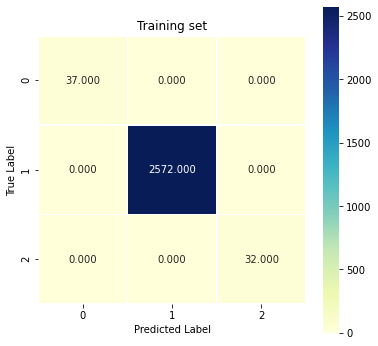

In [20]:
cm_nbtrainx1 = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrainx1, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

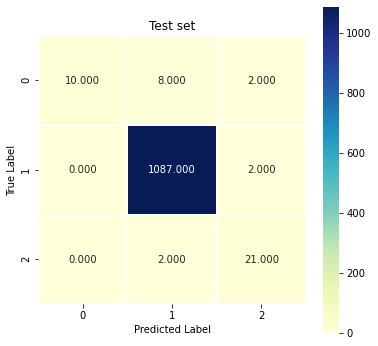

In [22]:
cm_nbtestx1 = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtestx1, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

In [23]:
print(f"precision of early in training: {cm_nbtrainx1[2,2]/np.sum(cm_nbtrainx1[:,2])}")
print(f"recall of early in training: {cm_nbtrainx1[2,2]/np.sum(cm_nbtrainx1[2])}")
print(f"precision of unclassified in training: {cm_nbtrainx1[0,0]/np.sum(cm_nbtrainx1[:,0])}")
print(f"recall of unclassified in training: {cm_nbtrainx1[0,0]/np.sum(cm_nbtrainx1[0])}")

print(f"precision of early in test: {cm_nbtestx1[2,2]/np.sum(cm_nbtestx1[:,2])}")
print(f"recall of early in test: {cm_nbtestx1[2,2]/np.sum(cm_nbtestx1[2])}")
print(f"precision of unclassified in test: {cm_nbtestx1[0,0]/np.sum(cm_nbtestx1[:,0])}")
print(f"recall of unclassified in test: {cm_nbtestx1[0,0]/np.sum(cm_nbtestx1[0])}")

print(f"F1 score (test, class 0) logistic regression {round(fmeas(cm_nbtest,0),3)}")
print(f"F1 score (test, class 2) logistic regression {round(fmeas(cm_nbtest,2),3)}")
print(f"F1 score (test, class 0) xgboost {round(fmeas(cm_nbtestx1,0),3)}")
print(f"F1 score (test, class 2) xgboost {round(fmeas(cm_nbtestx1,2),3)}")

precision of early in training: 1.0
recall of early in training: 1.0
precision of unclassified in training: 1.0
recall of unclassified in training: 1.0
precision of early in test: 0.84
recall of early in test: 0.9130434782608695
precision of unclassified in test: 1.0
recall of unclassified in test: 0.5
F1 score (test, class 0) logistic regression 0.486
F1 score (test, class 2) logistic regression 0.783
F1 score (test, class 0) xgboost 0.667
F1 score (test, class 2) xgboost 0.875


In training the labels are perfectly predicted. In the test also class 1 is also very good classified, only two truly late or predicted as different. In contrast, the prediction is less good for class 2 and even more for class 0. Especially, recall of unclassified is bad because the unclassified stars are wrongly classified because the class unclassfied as found by xgb is too narrow. That late is easiest is expected because late is the most abundant and most homogen class. Overall, the difference between test and tarining shows that there is overfitting. 
There is clear improvement compared to logistic regression.  

For counterimng overfitting the model needs to be changed. Given the few test samples best is a way with not too many free parameters. Therefore, I select subsample where there is only one parameter. 

In [24]:
modelx2 = XGBClassifier(subsample=0.5)
modelx2.fit(xsel_train, y_train)

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:05:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [25]:
y2_pred_train = modelx2.predict(xsel_train)
y2_pred_test = modelx2.predict(xsel_test)

There are still all right in the training set and clearly less in test set. There is some improvemnt in the test set, especially for the unclassified.

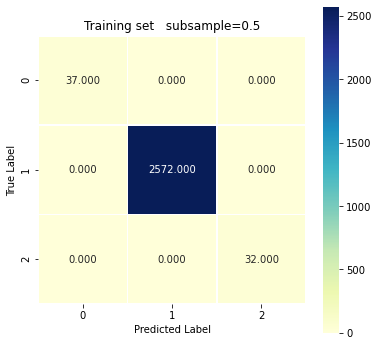

In [26]:
cm_nbtrainx2 = confusion_matrix(y_train, y2_pred_train)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrainx2, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set   subsample=0.5'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

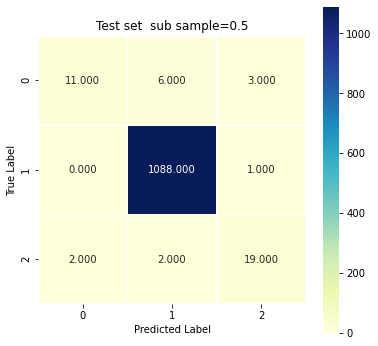

In [27]:
cm_nbtestx2 = confusion_matrix(y_test, y2_pred_test)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtestx2, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set  sub sample=0.5'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

In [28]:
print(f"precision of early in training: {cm_nbtrainx2[2,2]/np.sum(cm_nbtrainx2[:,2])}")
print(f"recall of early in training: {cm_nbtrainx2[2,2]/np.sum(cm_nbtrainx2[2])}")
print(f"precision of unclassified in training: {cm_nbtrainx2[0,0]/np.sum(cm_nbtrainx2[:,0])}")
print(f"recall of unclassified in training: {cm_nbtrainx2[0,0]/np.sum(cm_nbtrainx2[0])}")

print(f"precision of early in test: {cm_nbtestx2[2,2]/np.sum(cm_nbtestx2[:,2])}")
print(f"recall of early in test: {cm_nbtestx2[2,2]/np.sum(cm_nbtestx2[2])}")
print(f"precision of unclassified in test: {cm_nbtestx2[0,0]/np.sum(cm_nbtestx2[:,0])}")
print(f"recall of unclassified in test: {cm_nbtestx2[0,0]/np.sum(cm_nbtestx2[0])}")

print(f"F1 score (test, class 0) xgboost full sample {round(fmeas(cm_nbtestx1,0),3)}")
print(f"F1 score (test, class 2) xgboost full sample {round(fmeas(cm_nbtestx1,2),3)}")
print(f"F1 score (test, class 0) xgboost sample=0.5 {round(fmeas(cm_nbtestx2,0),3)}")
print(f"F1 score (test, class 2) xgboost sample=0.5 {round(fmeas(cm_nbtestx2,2),3)}")

precision of early in training: 1.0
recall of early in training: 1.0
precision of unclassified in training: 1.0
recall of unclassified in training: 1.0
precision of early in test: 0.8260869565217391
recall of early in test: 0.8260869565217391
precision of unclassified in test: 0.8461538461538461
recall of unclassified in test: 0.55
F1 score (test, class 0) xgboost full sample 0.667
F1 score (test, class 2) xgboost full sample 0.875
F1 score (test, class 0) xgboost sample=0.5 0.667
F1 score (test, class 2) xgboost sample=0.5 0.826


To explore the subsample paramter more we run more models systematically.

In [29]:
#In ress the are summariyed using the F1 score. 
#First the f1 score of the current models early and unclassufied and their average 
ress=np.zeros((7,10))
ress[0,0]=1.0
ress[1,0]=fmeas(cm_nbtrainx1,int(2))
ress[2,0]=fmeas(cm_nbtrainx1,int(0))
ress[3,0]=(ress[1,0]+ress[2,0])/2
ress[4,0]=fmeas(cm_nbtestx1,int(2))
ress[5,0]=fmeas(cm_nbtestx1,int(0))
ress[6,0]=(ress[4,0]+ress[5,0])/2
ress[0,1]=0.5
ress[1,1]=fmeas(cm_nbtrainx2,int(2))
ress[2,1]=fmeas(cm_nbtrainx2,int(0))
ress[3,1]=(ress[1,1]+ress[2,1])/2
ress[4,1]=fmeas(cm_nbtestx2,int(2))
ress[5,1]=fmeas(cm_nbtestx2,int(0))
ress[6,1]=(ress[4,1]+ress[5,1])/2
#defining the further subsample values
ress[0,2]=0.33
ress[0,3]=0.2
ress[0,4]=0.14
ress[0,5]=0.1
ress[0,6]=0.07
ress[0,7]=0.05
ress[0,8]=0.04
ress[0,9]=0.03

In [30]:
#running for more subsample values
for i in range(2,10):
    print(i)
    print(f"subsample of {ress[0,i]}")
    model3 = XGBClassifier(subsample=ress[0,i])  
    model3.fit(xsel_train,y_train)
    y3_pred_train = model3.predict(xsel_train)
    y3_pred_test = model3.predict(xsel_test)
    cm_nbtrain3 = confusion_matrix(y_train, y3_pred_train)
    cm_nbtest3 = confusion_matrix(y_test, y3_pred_test)
    ress[1,i]=fmeas(cm_nbtrain3,int(2))
    ress[2,i]=fmeas(cm_nbtrain3,int(0))
    ress[3,i]=(ress[1,i]+ress[2,i])/2
    ress[4,i]=fmeas(cm_nbtest3,int(2))
    ress[5,i]=fmeas(cm_nbtest3,int(0))
    ress[6,i]=(ress[4,i]+ress[5,i])/2

2
subsample of 0.33


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:06:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
3
subsample of 0.2
[16:06:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


4
subsample of 0.14
[16:06:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


5
subsample of 0.1
[16:06:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


6
subsample of 0.07
[16:06:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


7
subsample of 0.05
[16:06:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


8
subsample of 0.04
[16:06:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


9
subsample of 0.03
[16:06:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In training the score decreases continiously wuth subsample size. In the test sample the evolution of the F1-score is usually smaller overall and it is noisy with up and downs. The optimum values is different for unclassified and early. Overall the score is rather flat. Small subsample perform worse but including0.07 and bove there is no clear preferance, all achive about 0.73 to 0.82 as F1-score average over the two rare classes.

[0.77083333 0.74637681 0.81713555 0.79504505 0.78119658 0.72782705
 0.77960526 0.69886364 0.70559006 0.5042735 ]
[1.   0.5  0.33 0.2  0.14 0.1  0.07 0.05 0.04 0.03]


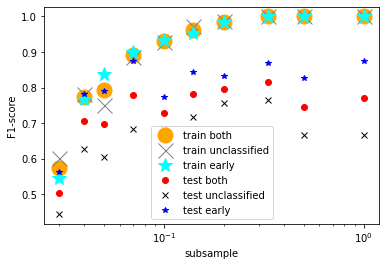

In [30]:
plt.plot(ress[0],ress[3],'o',ms=15,color='orange',label='train both') 
plt.plot(ress[0],ress[2],'x',ms=15,color='gray',label='train unclassified') 
plt.plot(ress[0],ress[1],'*',ms=15,color='cyan',label='train early') 
plt.plot(ress[0],ress[6],'o',color='red',label='test both') 
plt.plot(ress[0],ress[5],'x',color='black',label='test unclassified') 
plt.plot(ress[0],ress[4],'*',color='blue',label='test early') 
plt.legend(loc="best")
plt.xlabel("subsample")
plt.xscale("log")
plt.ylabel("F1-score")
print(ress[6])
print(ress[0])

Using different weights for the classes should improve performance for rare classes.

In [31]:
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)
print(np.min(classes_weights))
print(np.max(classes_weights))

0.34227579056505963
27.510416666666668


In [32]:
xgb_classifier8 = xgb.XGBClassifier(subsample=0.5)
xgb_classifier8.fit(xsel_train, y_train, sample_weight=classes_weights)

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:59:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [33]:
y8_pred_train = xgb_classifier8.predict(xsel_train)
y8_pred_test = xgb_classifier8.predict(xsel_test)

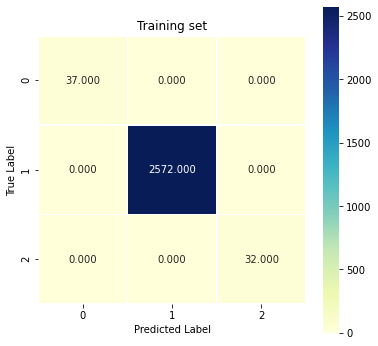

In [34]:
cm_nbtrain8 = confusion_matrix(y_train, y8_pred_train)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrain8, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

[[-1  1  0]
 [ 3 -4  1]
 [-2 -2  4]]
F1 score with w/o weights class 0: 0.667
F1 score with w/o weights class 2: 0.826
F1 score with weights class 0: 0.606
F1 score with weights class 2: 0.902


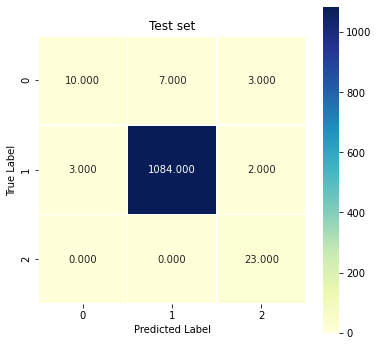

In [35]:
cm_nbtest8 = confusion_matrix(y_test, y8_pred_test)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtest8, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');
print(cm_nbtest8-cm_nbtestx2)  
print(f"F1 score with w/o weights class 0: {round(fmeas(cm_nbtestx2,0),3)}")
print(f"F1 score with w/o weights class 2: {round(fmeas(cm_nbtestx2,2),3)}")
print(f"F1 score with weights class 0: {round(fmeas(cm_nbtest8,0),3)}")
print(f"F1 score with weights class 2: {round(fmeas(cm_nbtest8,2),3)}")

Using weights in the fitting improves performance in the measures for the rare classes overall but not by by much because the number of corrected unclassified decreases. 

We now run weighted for all the same subsamples fraction as before. 

In [36]:
ress2=np.zeros((7,10))
ress2[0,:]=ress[0,:]
print(ress2[0,:])

[1.   0.5  0.33 0.2  0.14 0.1  0.07 0.05 0.04 0.03]


In [37]:
for i in range(10):
    print(f"sub sample of {ress2[0,i]}")
    xgb_classifier9 = xgb.XGBClassifier(subsample=ress2[0,i])
    xgb_classifier9.fit(xsel_train, y_train, sample_weight=classes_weights)
    y9_pred_train = xgb_classifier9.predict(xsel_train)
    y9_pred_test = xgb_classifier9.predict(xsel_test)
    cm_nbtrain9 = confusion_matrix(y_train, y9_pred_train)
    cm_nbtest9 = confusion_matrix(y_test, y9_pred_test)
    ress2[1,i]=fmeas(cm_nbtrain9,int(2))
    ress2[2,i]=fmeas(cm_nbtrain9,int(0))
    ress2[3,i]=(ress2[1,i]+ress2[2,i])/2
    ress2[4,i]=fmeas(cm_nbtest9,int(2))
    ress2[5,i]=fmeas(cm_nbtest9,int(0))
    ress2[6,i]=(ress2[4,i]+ress2[5,i])/2

sub sample of 1.0


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:59:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
sub sample of 0.5


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:59:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
sub sample of 0.33


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:00:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
sub sample of 0.2


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:00:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
sub sample of 0.14


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:00:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
sub sample of 0.1


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:00:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
sub sample of 0.07


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:00:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
sub sample of 0.05


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:00:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
sub sample of 0.04
[15:01:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



sub sample of 0.03


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:01:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Sub sample of 0.2 performs best for unclassified and is also close to best for early. In principle it still overfits the training data but when that is not anymore the care (below subsample of 0.1), the performance on the test data is also worse.

Text(0.5, 1.0, 'weighted fits')

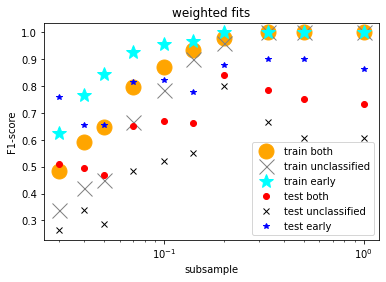

In [38]:
plt.plot(ress2[0],ress2[3],'o',ms=15,color='orange',label='train both') 
plt.plot(ress2[0],ress2[2],'x',ms=15,color='gray',label='train unclassified') 
plt.plot(ress2[0],ress2[1],'*',ms=15,color='cyan',label='train early') 
plt.plot(ress2[0],ress2[6],'o',color='red',label='test both') 
plt.plot(ress2[0],ress2[5],'x',color='black',label='test unclassified') 
plt.plot(ress2[0],ress2[4],'*',color='blue',label='test early') 
plt.legend(loc="best")
plt.xlabel("subsample")
plt.xscale("log")
plt.ylabel("F1-score")
plt.title("weighted fits")

Text(0, 0.5, 'test F1-score')

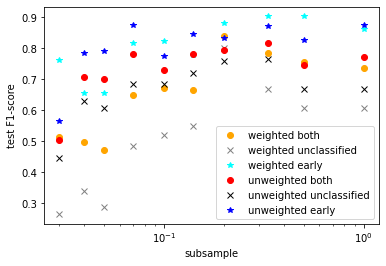

In [39]:
plt.plot(ress2[0],ress2[6],'o',color='orange',label='weighted both') 
plt.plot(ress2[0],ress2[5],'x',color='gray',label='weighted unclassified') 
plt.plot(ress2[0],ress2[4],'*',color='cyan',label='weighted early') 
plt.plot(ress[0],ress[6],'o',color='red',label='unweighted both') 
plt.plot(ress[0],ress[5],'x',color='black',label='unweighted unclassified') 
plt.plot(ress[0],ress[4],'*',color='blue',label='unweighted early') 
plt.legend(loc="best")
plt.xlabel("subsample")
plt.xscale("log")
plt.ylabel("test F1-score")

Intrinsic noisy (random variation between neighboring features) clearly affects the data. It is a a main reason for unclassified classifications. XGB has likely difficult to recognize that because the sample of unclassfied is too small that it can recognize it from the data. Therefore now the noise is added as an additional feature. The noise is the standard deviation between the features and the features smoothed with a Gaussian of a width of 1 pixel over the wavelength range between 2.08 and 2.29 were the features are normalized.  

In [40]:
#the noise lvel is feature is currently in the general labels at 7
print(f"noise is {yplus[4]}")
#add noise to new feature vector
print(f"current feature shape of traing set is {np.shape(xsel_train)}")
#create new features
xsel_train2=np.zeros((np.shape(xsel_train)[0],np.shape(xsel_train)[1]+1))
xsel_test2=np.zeros((np.shape(xsel_test)[0],np.shape(xsel_test)[1]+1))
#copy old 
xsel_train2[:,0:np.shape(xsel_train)[1]]=xsel_train
xsel_test2[:,0:np.shape(xsel_test)[1]]=xsel_test
#add noise as feature
xsel_train2[:,np.shape(xsel_train)[1]]=yplus_train[:,4]
xsel_test2[:,np.shape(xsel_test)[1]]=yplus_test[:,4]

noise is [ 54.56041175  58.37582071  49.42498075 ...  51.15859649  93.74415085
 146.37331923]
current feature shape of traing set is (2641, 1900)


Fit with subsample of 0.5 as before. 

In [41]:
model10 = XGBClassifier(subsample=0.5)
model10.fit(xsel_train2, y_train)

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:05:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [42]:
y10_pred_train = model10.predict(xsel_train2)
y10_pred_test = model10.predict(xsel_test2)

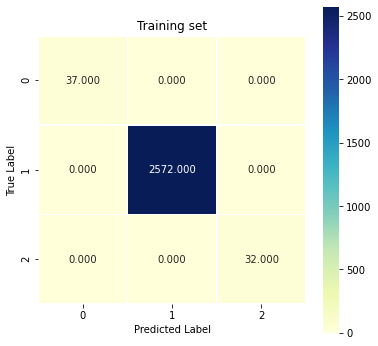

In [43]:
cm_nbtrain10 = confusion_matrix(y_train, y10_pred_train)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrain10, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

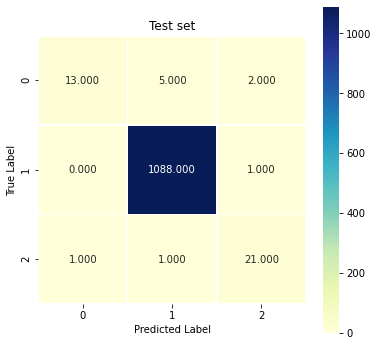

In [44]:
cm_nbtest10 = confusion_matrix(y_test, y10_pred_test)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtest10, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

The F1 score of early is on the same level as the best before. The one of unclassified is somewhat worse. However, we have not added weights here and also not tried subsample, thus the comparsion is not fair. 

In [45]:
print("all is for the test set")
print(f"F1-score unclassified {fmeas(cm_nbtest10,0)}")
print(f"best F1-score of unclassified before was {max(np.max(ress[5]),np.max(ress2[5]))}")
print(f"F1-score early {fmeas(cm_nbtest10,2)}")
print(f"best F1-score of early before was {max(np.max(ress[4]),np.max(ress2[4]))}")

all is for the test set
F1-score unclassified 0.7647058823529412
best F1-score of unclassified before was 0.8000000000000002
F1-score early 0.8936170212765957
best F1-score of early before was 0.9019607843137255


Now also adding weights to fit. 

In [46]:
xgb_classifier11 = xgb.XGBClassifier(subsample=0.5)
xgb_classifier11.fit(xsel_train2, y_train, sample_weight=classes_weights)

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:05:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [47]:
y11_pred_train = xgb_classifier11.predict(xsel_train2)
y11_pred_test = xgb_classifier11.predict(xsel_test2)

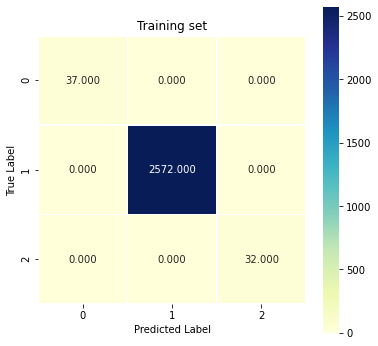

In [48]:
cm_nbtrain11 = confusion_matrix(y_train, y11_pred_train)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrain11, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

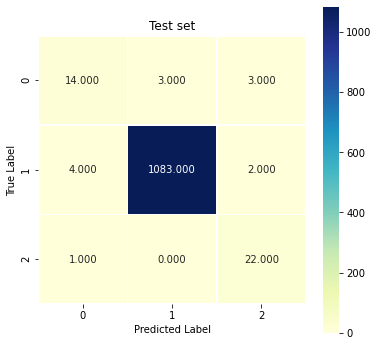

In [49]:
cm_nbtest11 = confusion_matrix(y_test, y11_pred_test)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtest11, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

With the weights the classification does not improve even for the rare classes. As expected there is also worse classification of the late labelled ones.

In [50]:
print("all is for the test set")
print(f"F1-score unclassified unweighted {fmeas(cm_nbtest10,0)}")
print(f"F1-score unclassified weighted {fmeas(cm_nbtest11,0)}")
print(f"F1-score early unweighted {fmeas(cm_nbtest10,2)}")
print(f"F1-score early weighted {fmeas(cm_nbtest11,2)}")

all is for the test set
F1-score unclassified unweighted 0.7647058823529412
F1-score unclassified weighted 0.717948717948718
F1-score early unweighted 0.8936170212765957
F1-score early weighted 0.8800000000000001


Now we run unweighted with the additional noise label for the same sub sample values as before. 

In [51]:
ress3=np.zeros((7,10))
ress3[0,:]=ress[0,:]
for i in range(10):
    print(f"subsample of {ress3[0,i]}")
    model3 = XGBClassifier(subsample=ress3[0,i])  
    model3.fit(xsel_train2,y_train)
    y3_pred_train = model3.predict(xsel_train2)
    y3_pred_test = model3.predict(xsel_test2)
    cm_nbtrain3 = confusion_matrix(y_train, y3_pred_train)
    cm_nbtest3 = confusion_matrix(y_test, y3_pred_test)
    ress3[1,i]=fmeas(cm_nbtrain3,int(2))
    ress3[2,i]=fmeas(cm_nbtrain3,int(0))
    ress3[3,i]=(ress3[1,i]+ress3[2,i])/2
    ress3[4,i]=fmeas(cm_nbtest3,int(2))
    ress3[5,i]=fmeas(cm_nbtest3,int(0))
    ress3[6,i]=(ress3[4,i]+ress3[5,i])/2

subsample of 1.0


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:05:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
subsample of 0.5


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
subsample of 0.33


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
subsample of 0.2


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
subsample of 0.14


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
subsample of 0.1


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:07:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
subsample of 0.07


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:07:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
subsample of 0.05


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:07:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
subsample of 0.04


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:07:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
subsample of 0.03


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:07:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Sub sample of 0.5 is clearly the best sub sample of all for the test set. The values for the others are rather similar besides of the lowest one for 0.03.

Text(0.5, 1.0, 'noise an additional label')

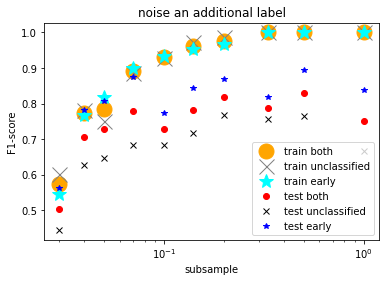

In [52]:
plt.plot(ress3[0],ress3[3],'o',ms=15,color='orange',label='train both') 
plt.plot(ress3[0],ress3[2],'x',ms=15,color='gray',label='train unclassified') 
plt.plot(ress3[0],ress3[1],'*',ms=15,color='cyan',label='train early') 
plt.plot(ress3[0],ress3[6],'o',color='red',label='test both') 
plt.plot(ress3[0],ress3[5],'x',color='black',label='test unclassified') 
plt.plot(ress3[0],ress3[4],'*',color='blue',label='test early') 
plt.legend(loc="best")
plt.xlabel("subsample")
plt.xscale("log")
plt.ylabel("F1-score")
plt.title("noise an additional label")

In [53]:
#other ideas as real three paramters *not much sense just would for pseudo expertise, or use lamba single parameter

In [58]:
#add neural network at least as trial 
print(np.shape(xsel_test))

(1132, 1900)


In [67]:
#small Neural network
modeln1 = Sequential(
    [              
        tf.keras.Input(shape=(1900,)),  
        Dense(5, activation="relu",  name="layer1"),  
        Dense(3, activation = 'linear', name="layer2")
    ], name = "modeln1"
) 
modeln1.summary()

Model: "modeln1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 5)                 9505      
                                                                 
 layer2 (Dense)              (None, 3)                 18        
                                                                 
Total params: 9,523
Trainable params: 9,523
Non-trainable params: 0
_________________________________________________________________


In [68]:
modeln1.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(0.001),
)

In [69]:
trainre=xsel_train[0:np.shape(xsel_train)[0]].reshape(np.shape(xsel_train)[0],np.shape(xsel_train)[1])
testre=xsel_test[0:np.shape(xsel_test)[0]].reshape(np.shape(xsel_test)[0],np.shape(xsel_test)[1])
resn1=np.zeros((5,10))
for i in range(10):
    print(i)
    modeln1.fit(
        xsel_train,y_train,
        epochs=320,batch_size=1900 #all at once because data set is not really large
    )
    resn1[0,i]=(i+1)*320
    prediction1p = modeln1.predict(trainre)
    sm_prediction1p = tf.nn.softmax(prediction1p).numpy()
    restrain=np.zeros(np.shape(prediction1p)[0])
    for j in range(np.shape(prediction1p)[0]): #most likely prediction
        restrain[j]=np.argmax(prediction1p[j])
    prediction1p_test = modeln1.predict(testre)
    sm_prediction1p_test = tf.nn.softmax(prediction1p_test).numpy()
    restest=np.zeros(np.shape(prediction1p_test)[0])
    for j in range(np.shape(prediction1p_test)[0]):
        restest[j]=np.argmax(prediction1p_test[j]) 
    cm_nbtrainn1 = confusion_matrix(y_train, restrain)
    cm_nbtestn1 = confusion_matrix(y_test, restest)
    resn1[1,i]=fmeas(cm_nbtrainn1,0) 
    resn1[2,i]=fmeas(cm_nbtrainn1,2)
    resn1[3,i]=fmeas(cm_nbtestn1,0)
    resn1[4,i]=fmeas(cm_nbtestn1,2)    

0
Epoch 1/320
2/2 [==============================] - 0s 6ms/step - loss: 2.4852
Epoch 2/320
2/2 [==============================] - 0s 7ms/step - loss: 1.0954
Epoch 3/320
2/2 [==============================] - 0s 8ms/step - loss: 1.0932
Epoch 4/320
2/2 [==============================] - 0s 7ms/step - loss: 1.0908
Epoch 5/320
2/2 [==============================] - 0s 10ms/step - loss: 1.0884
Epoch 6/320
2/2 [==============================] - 0s 8ms/step - loss: 1.0860
Epoch 7/320
2/2 [==============================] - 0s 7ms/step - loss: 1.0835
Epoch 8/320
2/2 [==============================] - 0s 8ms/step - loss: 1.0811
Epoch 9/320
2/2 [==============================] - 0s 7ms/step - loss: 1.0787
Epoch 10/320
2/2 [==============================] - 0s 10ms/step - loss: 1.0762
Epoch 11/320
2/2 [==============================] - 0s 7ms/step - loss: 1.0738
Epoch 12/320
2/2 [==============================] - 0s 8ms/step - loss: 1.0714
Epoch 13/320
2/2 [==============================] - 0s 10

2/2 [==============================] - 0s 8ms/step - loss: 0.6825
Epoch 207/320
2/2 [==============================] - 0s 6ms/step - loss: 0.6809
Epoch 208/320
2/2 [==============================] - 0s 7ms/step - loss: 0.6794
Epoch 209/320
2/2 [==============================] - 0s 8ms/step - loss: 0.6778
Epoch 210/320
2/2 [==============================] - 0s 7ms/step - loss: 0.6763
Epoch 211/320
2/2 [==============================] - 0s 8ms/step - loss: 0.6748
Epoch 212/320
2/2 [==============================] - 0s 7ms/step - loss: 0.6732
Epoch 213/320
2/2 [==============================] - 0s 7ms/step - loss: 0.6717
Epoch 214/320
2/2 [==============================] - 0s 9ms/step - loss: 0.6702
Epoch 215/320
2/2 [==============================] - 0s 7ms/step - loss: 0.6687
Epoch 216/320
2/2 [==============================] - 0s 8ms/step - loss: 0.6672
Epoch 217/320
2/2 [==============================] - 0s 9ms/step - loss: 0.6657
Epoch 218/320
2/2 [==============================] - 0

2/2 [==============================] - 0s 8ms/step - loss: 0.4438
Epoch 91/320
2/2 [==============================] - 0s 10ms/step - loss: 0.4430
Epoch 92/320
2/2 [==============================] - 0s 9ms/step - loss: 0.4421
Epoch 93/320
2/2 [==============================] - 0s 7ms/step - loss: 0.4413
Epoch 94/320
2/2 [==============================] - 0s 7ms/step - loss: 0.4404
Epoch 95/320
2/2 [==============================] - 0s 8ms/step - loss: 0.4396
Epoch 96/320
2/2 [==============================] - 0s 7ms/step - loss: 0.4388
Epoch 97/320
2/2 [==============================] - 0s 6ms/step - loss: 0.4379
Epoch 98/320
2/2 [==============================] - 0s 7ms/step - loss: 0.4371
Epoch 99/320
2/2 [==============================] - 0s 8ms/step - loss: 0.4363
Epoch 100/320
2/2 [==============================] - 0s 7ms/step - loss: 0.4354
Epoch 101/320
2/2 [==============================] - 0s 6ms/step - loss: 0.4346
Epoch 102/320
2/2 [==============================] - 0s 8ms/st

2/2 [==============================] - 0s 6ms/step - loss: 0.3141
Epoch 295/320
2/2 [==============================] - 0s 11ms/step - loss: 0.3136
Epoch 296/320
2/2 [==============================] - 0s 6ms/step - loss: 0.3131
Epoch 297/320
2/2 [==============================] - 0s 13ms/step - loss: 0.3127
Epoch 298/320
2/2 [==============================] - 0s 7ms/step - loss: 0.3122
Epoch 299/320
2/2 [==============================] - 0s 8ms/step - loss: 0.3118
Epoch 300/320
2/2 [==============================] - 0s 8ms/step - loss: 0.3113
Epoch 301/320
2/2 [==============================] - 0s 6ms/step - loss: 0.3108
Epoch 302/320
2/2 [==============================] - 0s 6ms/step - loss: 0.3104
Epoch 303/320
2/2 [==============================] - 0s 9ms/step - loss: 0.3099
Epoch 304/320
2/2 [==============================] - 0s 7ms/step - loss: 0.3095
Epoch 305/320
2/2 [==============================] - 0s 7ms/step - loss: 0.3090
Epoch 306/320
2/2 [==============================] -

2/2 [==============================] - 0s 8ms/step - loss: 0.2424
Epoch 179/320
2/2 [==============================] - 0s 6ms/step - loss: 0.2421
Epoch 180/320
2/2 [==============================] - 0s 8ms/step - loss: 0.2419
Epoch 181/320
2/2 [==============================] - 0s 7ms/step - loss: 0.2416
Epoch 182/320
2/2 [==============================] - 0s 8ms/step - loss: 0.2413
Epoch 183/320
2/2 [==============================] - 0s 7ms/step - loss: 0.2411
Epoch 184/320
2/2 [==============================] - 0s 6ms/step - loss: 0.2408
Epoch 185/320
2/2 [==============================] - 0s 7ms/step - loss: 0.2406
Epoch 186/320
2/2 [==============================] - 0s 10ms/step - loss: 0.2403
Epoch 187/320
2/2 [==============================] - 0s 8ms/step - loss: 0.2400
Epoch 188/320
2/2 [==============================] - 0s 8ms/step - loss: 0.2398
Epoch 189/320
2/2 [==============================] - 0s 9ms/step - loss: 0.2395
Epoch 190/320
2/2 [==============================] - 

2/2 [==============================] - 0s 10ms/step - loss: 0.2013
Epoch 62/320
2/2 [==============================] - 0s 9ms/step - loss: 0.2012
Epoch 63/320
2/2 [==============================] - 0s 9ms/step - loss: 0.2010
Epoch 64/320
2/2 [==============================] - 0s 9ms/step - loss: 0.2008
Epoch 65/320
2/2 [==============================] - 0s 7ms/step - loss: 0.2007
Epoch 66/320
2/2 [==============================] - 0s 8ms/step - loss: 0.2005
Epoch 67/320
2/2 [==============================] - 0s 9ms/step - loss: 0.2004
Epoch 68/320
2/2 [==============================] - 0s 8ms/step - loss: 0.2002
Epoch 69/320
2/2 [==============================] - 0s 10ms/step - loss: 0.2001
Epoch 70/320
2/2 [==============================] - 0s 10ms/step - loss: 0.1999
Epoch 71/320
2/2 [==============================] - 0s 9ms/step - loss: 0.1998
Epoch 72/320
2/2 [==============================] - 0s 10ms/step - loss: 0.1996
Epoch 73/320
2/2 [==============================] - 0s 10ms/s

2/2 [==============================] - 0s 8ms/step - loss: 0.1767
Epoch 266/320
2/2 [==============================] - 0s 8ms/step - loss: 0.1766
Epoch 267/320
2/2 [==============================] - 0s 8ms/step - loss: 0.1765
Epoch 268/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1764
Epoch 269/320
2/2 [==============================] - 0s 9ms/step - loss: 0.1763
Epoch 270/320
2/2 [==============================] - 0s 9ms/step - loss: 0.1762
Epoch 271/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1761
Epoch 272/320
2/2 [==============================] - 0s 9ms/step - loss: 0.1760
Epoch 273/320
2/2 [==============================] - 0s 8ms/step - loss: 0.1759
Epoch 274/320
2/2 [==============================] - 0s 10ms/step - loss: 0.1759
Epoch 275/320
2/2 [==============================] - 0s 9ms/step - loss: 0.1758
Epoch 276/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1757
Epoch 277/320
2/2 [==============================] - 

2/2 [==============================] - 0s 7ms/step - loss: 0.1616
Epoch 150/320
2/2 [==============================] - 0s 10ms/step - loss: 0.1616
Epoch 151/320
2/2 [==============================] - 0s 9ms/step - loss: 0.1615
Epoch 152/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1615
Epoch 153/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1614
Epoch 154/320
2/2 [==============================] - 0s 6ms/step - loss: 0.1614
Epoch 155/320
2/2 [==============================] - 0s 5ms/step - loss: 0.1613
Epoch 156/320
2/2 [==============================] - 0s 9ms/step - loss: 0.1613
Epoch 157/320
2/2 [==============================] - 0s 8ms/step - loss: 0.1612
Epoch 158/320
2/2 [==============================] - 0s 8ms/step - loss: 0.1611
Epoch 159/320
2/2 [==============================] - 0s 6ms/step - loss: 0.1611
Epoch 160/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1610
Epoch 161/320
2/2 [==============================] - 

2/2 [==============================] - 0s 9ms/step - loss: 0.1524
Epoch 33/320
2/2 [==============================] - 0s 8ms/step - loss: 0.1524
Epoch 34/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1524
Epoch 35/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1523
Epoch 36/320
2/2 [==============================] - 0s 9ms/step - loss: 0.1523
Epoch 37/320
2/2 [==============================] - 0s 6ms/step - loss: 0.1522
Epoch 38/320
2/2 [==============================] - 0s 6ms/step - loss: 0.1522
Epoch 39/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1522
Epoch 40/320
2/2 [==============================] - 0s 8ms/step - loss: 0.1521
Epoch 41/320
2/2 [==============================] - 0s 6ms/step - loss: 0.1521
Epoch 42/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1521
Epoch 43/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1520
Epoch 44/320
2/2 [==============================] - 0s 8ms/step -

2/2 [==============================] - 0s 10ms/step - loss: 0.1467
Epoch 238/320
2/2 [==============================] - 0s 9ms/step - loss: 0.1467
Epoch 239/320
2/2 [==============================] - 0s 10ms/step - loss: 0.1466
Epoch 240/320
2/2 [==============================] - 0s 9ms/step - loss: 0.1466
Epoch 241/320
2/2 [==============================] - 0s 8ms/step - loss: 0.1466
Epoch 242/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1466
Epoch 243/320
2/2 [==============================] - 0s 8ms/step - loss: 0.1466
Epoch 244/320
2/2 [==============================] - 0s 9ms/step - loss: 0.1465
Epoch 245/320
2/2 [==============================] - 0s 6ms/step - loss: 0.1465
Epoch 246/320
2/2 [==============================] - 0s 6ms/step - loss: 0.1465
Epoch 247/320
2/2 [==============================] - 0s 9ms/step - loss: 0.1465
Epoch 248/320
2/2 [==============================] - 0s 8ms/step - loss: 0.1465
Epoch 249/320
2/2 [==============================] -

2/2 [==============================] - 0s 8ms/step - loss: 0.1432
Epoch 122/320
2/2 [==============================] - 0s 13ms/step - loss: 0.1432
Epoch 123/320
2/2 [==============================] - 0s 8ms/step - loss: 0.1432
Epoch 124/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1432
Epoch 125/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1432
Epoch 126/320
2/2 [==============================] - 0s 9ms/step - loss: 0.1432
Epoch 127/320
2/2 [==============================] - 0s 6ms/step - loss: 0.1431
Epoch 128/320
2/2 [==============================] - 0s 9ms/step - loss: 0.1431
Epoch 129/320
2/2 [==============================] - 0s 8ms/step - loss: 0.1431
Epoch 130/320
2/2 [==============================] - 0s 9ms/step - loss: 0.1431
Epoch 131/320
2/2 [==============================] - 0s 9ms/step - loss: 0.1431
Epoch 132/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1431
Epoch 133/320
2/2 [==============================] - 

2/2 [==============================] - 0s 7ms/step - loss: 0.1412
Epoch 5/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1412
Epoch 6/320
2/2 [==============================] - 0s 6ms/step - loss: 0.1412
Epoch 7/320
2/2 [==============================] - 0s 6ms/step - loss: 0.1412
Epoch 8/320
2/2 [==============================] - 0s 6ms/step - loss: 0.1412
Epoch 9/320
2/2 [==============================] - 0s 5ms/step - loss: 0.1412
Epoch 10/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1412
Epoch 11/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1411
Epoch 12/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1411
Epoch 13/320
2/2 [==============================] - 0s 6ms/step - loss: 0.1411
Epoch 14/320
2/2 [==============================] - 0s 9ms/step - loss: 0.1411
Epoch 15/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1411
Epoch 16/320
2/2 [==============================] - 0s 8ms/step - loss

2/2 [==============================] - 0s 9ms/step - loss: 0.1401
Epoch 210/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1401
Epoch 211/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1401
Epoch 212/320
2/2 [==============================] - 0s 6ms/step - loss: 0.1401
Epoch 213/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1401
Epoch 214/320
2/2 [==============================] - 0s 8ms/step - loss: 0.1401
Epoch 215/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1401
Epoch 216/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1400
Epoch 217/320
2/2 [==============================] - 0s 8ms/step - loss: 0.1400
Epoch 218/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1400
Epoch 219/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1400
Epoch 220/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1400
Epoch 221/320
2/2 [==============================] - 0

2/2 [==============================] - 0s 7ms/step - loss: 0.1395
Epoch 94/320
2/2 [==============================] - 0s 8ms/step - loss: 0.1395
Epoch 95/320
2/2 [==============================] - 0s 9ms/step - loss: 0.1395
Epoch 96/320
2/2 [==============================] - 0s 8ms/step - loss: 0.1395
Epoch 97/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1395
Epoch 98/320
2/2 [==============================] - 0s 8ms/step - loss: 0.1395
Epoch 99/320
2/2 [==============================] - 0s 8ms/step - loss: 0.1395
Epoch 100/320
2/2 [==============================] - 0s 8ms/step - loss: 0.1395
Epoch 101/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1395
Epoch 102/320
2/2 [==============================] - 0s 8ms/step - loss: 0.1395
Epoch 103/320
2/2 [==============================] - 0s 10ms/step - loss: 0.1395
Epoch 104/320
2/2 [==============================] - 0s 8ms/step - loss: 0.1395
Epoch 105/320
2/2 [==============================] - 0s 6ms

2/2 [==============================] - 0s 11ms/step - loss: 0.1392
Epoch 298/320
2/2 [==============================] - 0s 8ms/step - loss: 0.1392
Epoch 299/320
2/2 [==============================] - 0s 13ms/step - loss: 0.1392
Epoch 300/320
2/2 [==============================] - 0s 10ms/step - loss: 0.1392
Epoch 301/320
2/2 [==============================] - 0s 13ms/step - loss: 0.1392
Epoch 302/320
2/2 [==============================] - 0s 10ms/step - loss: 0.1392
Epoch 303/320
2/2 [==============================] - 0s 13ms/step - loss: 0.1392
Epoch 304/320
2/2 [==============================] - 0s 8ms/step - loss: 0.1392
Epoch 305/320
2/2 [==============================] - 0s 8ms/step - loss: 0.1392
Epoch 306/320
2/2 [==============================] - 0s 11ms/step - loss: 0.1392
Epoch 307/320
2/2 [==============================] - 0s 9ms/step - loss: 0.1392
Epoch 308/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1392
Epoch 309/320
2/2 [============================

2/2 [==============================] - 0s 8ms/step - loss: 0.1391
Epoch 181/320
2/2 [==============================] - 0s 9ms/step - loss: 0.1391
Epoch 182/320
2/2 [==============================] - 0s 9ms/step - loss: 0.1391
Epoch 183/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1391
Epoch 184/320
2/2 [==============================] - 0s 9ms/step - loss: 0.1391
Epoch 185/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1391
Epoch 186/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1391
Epoch 187/320
2/2 [==============================] - 0s 8ms/step - loss: 0.1391
Epoch 188/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1391
Epoch 189/320
2/2 [==============================] - 0s 8ms/step - loss: 0.1391
Epoch 190/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1391
Epoch 191/320
2/2 [==============================] - 0s 7ms/step - loss: 0.1391
Epoch 192/320
2/2 [==============================] - 0

In [70]:


print(f"two example output vectors:\n {prediction1p[0:2]}")
print("not classified: largest value", np.max(prediction1p[:,0]), "smallest value", np.min(prediction1p[:,0]))
print("late-type: largest value", np.max(prediction1p[:,1]), "smallest value", np.min(prediction1p[:,1]))
print("early-type: largest value", np.max(prediction1p[:,2]), "smallest value", np.min(prediction1p[:,2]))
print(f"two example output vectors probability:\n {sm_prediction1p[:2]}")


print(f"train value {y_train[0:20]}")
print(f"train predictions {restrain[0:20]}")
print(f"test values {y_test[0:20]}")
print(f"test predictions {restest[0:20]}")

two example output vectors:
 [[-2.0801334  2.1407936 -2.1935027]
 [-2.0801334  2.1407936 -2.1935027]]
not classified: largest value -2.0801334 smallest value -2.0801334
late-type: largest value 2.1407936 smallest value 2.1407936
early-type: largest value -2.1935027 smallest value -2.1935027
two example output vectors probability:
 [[0.01428787 0.9729555  0.01275652]
 [0.01428787 0.9729555  0.01275652]]
train value [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
train predictions [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
test values [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
test predictions [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


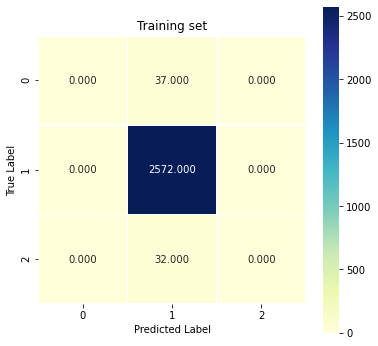

In [71]:

cm_nbtrainn1 = confusion_matrix(y_train, restrain)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrainn1, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

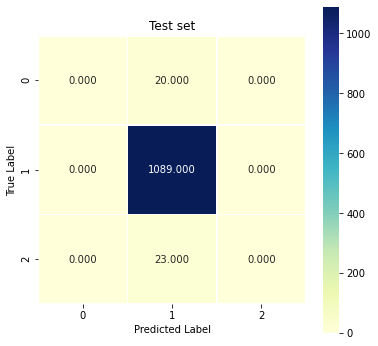

In [72]:
cm_nbtestn1 = confusion_matrix(y_test, restest)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtestn1, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

In [73]:
print(f"F1 score (train, class 0) {round(fmeas(cm_nbtrainn1,0),3)}")
print(f"F1 score (train, class 2) {round(fmeas(cm_nbtrainn1,2),3)}")
print(f"F1 score (test, class 0) {round(fmeas(cm_nbtestn1,0),3)}")
print(f"F1 score (test, class 2) {round(fmeas(cm_nbtestn1,2),3)}")

F1 score (train, class 0) 0
F1 score (train, class 2) 0
F1 score (test, class 0) 0
F1 score (test, class 2) 0


Text(0, 0.5, 'F1-score')

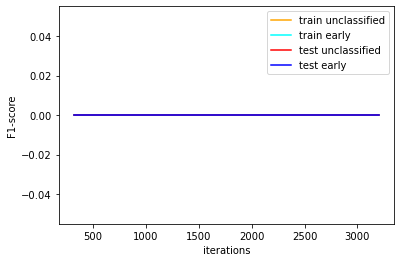

In [74]:
plt.plot(resn1[0],resn1[1],'-',color='orange',ms=10,label='train unclassified') 
plt.plot(resn1[0],resn1[2],'-',color='cyan',ms=10,label='train early') 
plt.plot(resn1[0],resn1[3],'-',color='red',ms=10,label='test unclassified') 
plt.plot(resn1[0],resn1[4],'-',color='blue',ms=10,label='test early') 
plt.legend(loc="best")
plt.xlabel("iterations")
plt.ylabel("F1-score")
#last trial had only class 0 correct in training
#second no rare good 

In [81]:
modeln2 = Sequential(
    [              
        tf.keras.Input(shape=(1900,)),    
        Dense(8, activation="relu", name="layer1"), #, kernel_regularizer=tf.keras.regularizers.L1(0.01))   
        Dense(5, activation="relu", name="layer2"),
        Dense(3, activation = 'linear', name="layer3"),
    ], name = "modeln2"
) 
modeln2.summary()

Model: "modeln2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 8)                 15208     
                                                                 
 layer2 (Dense)              (None, 5)                 45        
                                                                 
 layer3 (Dense)              (None, 3)                 18        
                                                                 
Total params: 15,271
Trainable params: 15,271
Non-trainable params: 0
_________________________________________________________________


In [82]:
modeln2.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(0.001),
)

In [83]:
resn2=np.zeros((5,10))
for i in range(10):
    print(i)
    modeln2.fit(
        xsel_train,y_train,
        epochs=320,batch_size=1900 #all at once because data set is not really large
    )
    resn2[0,i]=(i+1)*320
    prediction1p = modeln2.predict(trainre)
    sm_prediction1p = tf.nn.softmax(prediction1p).numpy()
    restrain=np.zeros(np.shape(prediction1p)[0])
    for j in range(np.shape(prediction1p)[0]): #most likely prediction
        restrain[j]=np.argmax(prediction1p[j])
    prediction1p_test = modeln2.predict(testre)
    sm_prediction1p_test = tf.nn.softmax(prediction1p_test).numpy()
    restest=np.zeros(np.shape(prediction1p_test)[0])
    for j in range(np.shape(prediction1p_test)[0]):
        restest[j]=np.argmax(prediction1p_test[j]) 
    cm_nbtrainn1 = confusion_matrix(y_train, restrain)
    cm_nbtestn1 = confusion_matrix(y_test, restest)
    resn2[1,i]=fmeas(cm_nbtrainn1,0) 
    resn2[2,i]=fmeas(cm_nbtrainn1,2)
    resn2[3,i]=fmeas(cm_nbtestn1,0)
    resn2[4,i]=fmeas(cm_nbtestn1,2)  

0
Epoch 1/320
2/2 [==============================] - 0s 7ms/step - loss: 0.6841
Epoch 2/320
2/2 [==============================] - 0s 9ms/step - loss: 0.2307
Epoch 3/320
2/2 [==============================] - 0s 8ms/step - loss: 0.1992
Epoch 4/320
2/2 [==============================] - 0s 8ms/step - loss: 0.2250
Epoch 5/320
2/2 [==============================] - 0s 8ms/step - loss: 0.2470
Epoch 6/320
2/2 [==============================] - 0s 7ms/step - loss: 0.2580
Epoch 7/320
2/2 [==============================] - 0s 9ms/step - loss: 0.2608
Epoch 8/320
2/2 [==============================] - 0s 7ms/step - loss: 0.2566
Epoch 9/320
2/2 [==============================] - 0s 7ms/step - loss: 0.2465
Epoch 10/320
2/2 [==============================] - 0s 7ms/step - loss: 0.2335
Epoch 11/320
2/2 [==============================] - 0s 7ms/step - loss: 0.2187
Epoch 12/320
2/2 [==============================] - 0s 7ms/step - loss: 0.2047
Epoch 13/320
2/2 [==============================] - 0s 9ms/

2/2 [==============================] - 0s 6ms/step - loss: 0.0547
Epoch 207/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0546
Epoch 208/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0544
Epoch 209/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0542
Epoch 210/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0543
Epoch 211/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0542
Epoch 212/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0540
Epoch 213/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0538
Epoch 214/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0537
Epoch 215/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0538
Epoch 216/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0535
Epoch 217/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0533
Epoch 218/320
2/2 [==============================] - 0

2/2 [==============================] - 0s 6ms/step - loss: 0.0325
Epoch 91/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0315
Epoch 92/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0317
Epoch 93/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0315
Epoch 94/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0315
Epoch 95/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0311
Epoch 96/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0309
Epoch 97/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0308
Epoch 98/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0307
Epoch 99/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0306
Epoch 100/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0305
Epoch 101/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0305
Epoch 102/320
2/2 [==============================] - 0s 7ms/ste

2/2 [==============================] - 0s 7ms/step - loss: 0.0147
Epoch 295/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0148
Epoch 296/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0148
Epoch 297/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0143
Epoch 298/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0145
Epoch 299/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0142
Epoch 300/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0142
Epoch 301/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0143
Epoch 302/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0147
Epoch 303/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0141
Epoch 304/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0151
Epoch 305/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0142
Epoch 306/320
2/2 [==============================] - 0

2/2 [==============================] - 0s 6ms/step - loss: 0.0091
Epoch 179/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0081
Epoch 180/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0080
Epoch 181/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0079
Epoch 182/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0080
Epoch 183/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0076
Epoch 184/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0078
Epoch 185/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0075
Epoch 186/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0076
Epoch 187/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0076
Epoch 188/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0074
Epoch 189/320
2/2 [==============================] - 0s 11ms/step - loss: 0.0075
Epoch 190/320
2/2 [==============================] - 

Epoch 62/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0043
Epoch 63/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0044
Epoch 64/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0042
Epoch 65/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0044
Epoch 66/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0044
Epoch 67/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0050
Epoch 68/320
2/2 [==============================] - 0s 14ms/step - loss: 0.0047
Epoch 69/320
2/2 [==============================] - 0s 10ms/step - loss: 0.0060
Epoch 70/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0053
Epoch 71/320
2/2 [==============================] - 0s 10ms/step - loss: 0.0046
Epoch 72/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0050
Epoch 73/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0052
Epoch 74/320
2/2 [==============================]

2/2 [==============================] - 0s 11ms/step - loss: 0.0029
Epoch 267/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0029
Epoch 268/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0029
Epoch 269/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0029
Epoch 270/320
2/2 [==============================] - 0s 9ms/step - loss: 0.0029
Epoch 271/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0029
Epoch 272/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0029
Epoch 273/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0029
Epoch 274/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0029
Epoch 275/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0029
Epoch 276/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0029
Epoch 277/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0029
Epoch 278/320
2/2 [==============================] - 

2/2 [==============================] - 0s 7ms/step - loss: 0.0023
Epoch 151/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 152/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 153/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 154/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 155/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 156/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 157/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 158/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 159/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 160/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 161/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0024
Epoch 162/320
2/2 [==============================] - 0

2/2 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 34/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 35/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 36/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 37/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 38/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 39/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 40/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 41/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 42/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 43/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 44/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 45/320
2/2 [==============================] - 0s 7ms/step -

2/2 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 239/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 240/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 241/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 242/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 243/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 244/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 245/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 246/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 247/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 248/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 249/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 250/320
2/2 [==============================] - 0

2/2 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 123/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 124/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 125/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 126/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 127/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 128/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 129/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 130/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 131/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 132/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 133/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 134/320
2/2 [==============================] - 0

2/2 [==============================] - 0s 7ms/step - loss: 0.0014
Epoch 6/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 7/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 8/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0016
Epoch 9/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 10/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0028
Epoch 11/320
2/2 [==============================] - 0s 10ms/step - loss: 0.0017
Epoch 12/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 13/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 14/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 15/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0045
Epoch 16/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0770
Epoch 17/320
2/2 [==============================] - 0s 7ms/step - lo

2/2 [==============================] - 0s 6ms/step - loss: 0.0070
Epoch 211/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0071
Epoch 212/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0071
Epoch 213/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0070
Epoch 214/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0070
Epoch 215/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0070
Epoch 216/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0069
Epoch 217/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0069
Epoch 218/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0069
Epoch 219/320
2/2 [==============================] - 0s 8ms/step - loss: 0.0070
Epoch 220/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0069
Epoch 221/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0069
Epoch 222/320
2/2 [==============================] - 0

2/2 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 95/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0061
Epoch 96/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0059
Epoch 97/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0055
Epoch 98/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0052
Epoch 99/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0058
Epoch 100/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0058
Epoch 101/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 102/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 103/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0057
Epoch 104/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 105/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 106/320
2/2 [==============================] - 0s 7ms

2/2 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 299/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0042
Epoch 300/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 301/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 302/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0044
Epoch 303/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 304/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0042
Epoch 305/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0041
Epoch 306/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 307/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 308/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 309/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0041
Epoch 310/320
2/2 [==============================] - 0

2/2 [==============================] - 0s 8ms/step - loss: 0.0036
Epoch 183/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 184/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 185/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0035
Epoch 186/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 187/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 188/320
2/2 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 189/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0035
Epoch 190/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 191/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0034
Epoch 192/320
2/2 [==============================] - 0s 6ms/step - loss: 0.0035
Epoch 193/320
2/2 [==============================] - 0s 5ms/step - loss: 0.0034
Epoch 194/320
2/2 [==============================] - 0

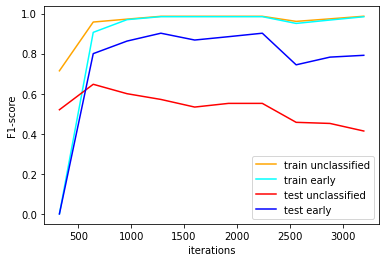

In [85]:
plt.plot(resn2[0],resn2[1],'-',color='orange',ms=10,label='train unclassified') 
plt.plot(resn2[0],resn2[2],'-',color='cyan',ms=10,label='train early') 
plt.plot(resn2[0],resn2[3],'-',color='red',ms=10,label='test unclassified') 
plt.plot(resn2[0],resn2[4],'-',color='blue',ms=10,label='test early') 
plt.legend(loc="best")
plt.xlabel("iterations")
plt.ylabel("F1-score")
#Trial 1 first gets early *but train worse than test) and then fits unclassified
#Trial 2 gets it right saved as
np.savetxt("class_twolayer_nn_v1.txt",resn2)

As visisble the perfermance reduces after 1000 to 2000 iterations. Thus there there is overfitting and we need to regularize to avoid it.

In [43]:
#1D convolution
xsel_trainc = xsel_train.reshape(xsel_train.shape[0], round(xsel_train.shape[1]/25), 25)
xsel_testc = xsel_test.reshape(xsel_test.shape[0], round(xsel_test.shape[1]/25), 25)
print(np.shape(xsel_trainc))

(2641, 76, 25)


In [50]:
model6 = Sequential(
    [              
        Conv1D(38,16, activation="relu",strides=1, padding="same", name="layer1",input_shape=(76,25)),   #25 pieces of 76 length, no overlapping 
        MaxPooling1D(pool_size=8),
        Flatten(),
        Dense(10, activation="relu", name="layer3"),        
        Dense(3, activation = "linear")
    ], name = "model6"
) 
model6.summary()
#need to understand conv1d more (probably check conv2v also )

Model: "model6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Conv1D)             (None, 76, 38)            15238     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 9, 38)            0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 342)               0         
                                                                 
 layer3 (Dense)              (None, 10)                3430      
                                                                 
 dense_5 (Dense)             (None, 3)                 33        
                                                                 
Total params: 18,701
Trainable params: 18,701
Non-trainable params: 0
________________________________________________________

In [51]:
model6.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(0.001),
)

In [52]:
resn6=np.zeros((5,10))
for i in range(10):
    print(i)
    model6.fit(
        xsel_trainc,y_train,
        epochs=100,batch_size=1900) #all at once because data set is not really large
    
    resn6[0,i]=(i+1)*100
    prediction1p = model6.predict(xsel_trainc)
    sm_prediction1p = tf.nn.softmax(prediction1p).numpy()
    restrain=np.zeros(np.shape(prediction1p)[0])
    for j in range(np.shape(prediction1p)[0]): #most likely prediction
        restrain[j]=np.argmax(prediction1p[j])
    prediction1p_test = model6.predict(xsel_testc)
    sm_prediction1p_test = tf.nn.softmax(prediction1p_test).numpy()
    restest=np.zeros(np.shape(prediction1p_test)[0])
    for j in range(np.shape(prediction1p_test)[0]):
        restest[j]=np.argmax(prediction1p_test[j]) 
    cm_nbtrainn1 = confusion_matrix(y_train, restrain)
    cm_nbtestn1 = confusion_matrix(y_test, restest)
    resn6[1,i]=fmeas(cm_nbtrainn1,0) 
    resn6[2,i]=fmeas(cm_nbtrainn1,2)
    resn6[3,i]=fmeas(cm_nbtestn1,0)
    resn6[4,i]=fmeas(cm_nbtestn1,2)  

0
Epoch 1/100
2/2 [==============================] - 1s 66ms/step - loss: 1.7428
Epoch 2/100
2/2 [==============================] - 0s 67ms/step - loss: 1.2123
Epoch 3/100
2/2 [==============================] - 0s 72ms/step - loss: 1.0641
Epoch 4/100
2/2 [==============================] - 0s 79ms/step - loss: 1.0365
Epoch 5/100
2/2 [==============================] - 0s 81ms/step - loss: 1.0195
Epoch 6/100
2/2 [==============================] - 0s 70ms/step - loss: 1.0148
Epoch 7/100
2/2 [==============================] - 0s 75ms/step - loss: 1.0090
Epoch 8/100
2/2 [==============================] - 0s 68ms/step - loss: 0.9981
Epoch 9/100
2/2 [==============================] - 0s 69ms/step - loss: 0.9861
Epoch 10/100
2/2 [==============================] - 0s 79ms/step - loss: 0.9753
Epoch 11/100
2/2 [==============================] - 0s 69ms/step - loss: 0.9658
Epoch 12/100
2/2 [==============================] - 0s 67ms/step - loss: 0.9566
Epoch 13/100
2/2 [=============================

2/2 [==============================] - 0s 90ms/step - loss: 0.1223
Epoch 3/100
2/2 [==============================] - 0s 89ms/step - loss: 0.1204
Epoch 4/100
2/2 [==============================] - 0s 79ms/step - loss: 0.1198
Epoch 5/100
2/2 [==============================] - 0s 71ms/step - loss: 0.1166
Epoch 6/100
2/2 [==============================] - 0s 70ms/step - loss: 0.1157
Epoch 7/100
2/2 [==============================] - 0s 66ms/step - loss: 0.1141
Epoch 8/100
2/2 [==============================] - 0s 70ms/step - loss: 0.1131
Epoch 9/100
2/2 [==============================] - 0s 80ms/step - loss: 0.1117
Epoch 10/100
2/2 [==============================] - 0s 67ms/step - loss: 0.1105
Epoch 11/100
2/2 [==============================] - 0s 78ms/step - loss: 0.1101
Epoch 12/100
2/2 [==============================] - 0s 90ms/step - loss: 0.1090
Epoch 13/100
2/2 [==============================] - 0s 72ms/step - loss: 0.1074
Epoch 14/100
2/2 [==============================] - 0s 72ms/

2/2 [==============================] - 0s 92ms/step - loss: 0.0387
Epoch 5/100
2/2 [==============================] - 0s 99ms/step - loss: 0.0387
Epoch 6/100
2/2 [==============================] - 0s 109ms/step - loss: 0.0383
Epoch 7/100
2/2 [==============================] - 0s 99ms/step - loss: 0.0390
Epoch 8/100
2/2 [==============================] - 0s 103ms/step - loss: 0.0390
Epoch 9/100
2/2 [==============================] - 0s 107ms/step - loss: 0.0389
Epoch 10/100
2/2 [==============================] - 0s 94ms/step - loss: 0.0386
Epoch 11/100
2/2 [==============================] - 0s 92ms/step - loss: 0.0394
Epoch 12/100
2/2 [==============================] - 0s 101ms/step - loss: 0.0382
Epoch 13/100
2/2 [==============================] - 0s 109ms/step - loss: 0.0382
Epoch 14/100
2/2 [==============================] - 0s 99ms/step - loss: 0.0382
Epoch 15/100
2/2 [==============================] - 0s 94ms/step - loss: 0.0381
Epoch 16/100
2/2 [==============================] - 0

2/2 [==============================] - 0s 110ms/step - loss: 0.0290
Epoch 5/100
2/2 [==============================] - 0s 136ms/step - loss: 0.0290
Epoch 6/100
2/2 [==============================] - 0s 113ms/step - loss: 0.0287
Epoch 7/100
2/2 [==============================] - 0s 110ms/step - loss: 0.0286
Epoch 8/100
2/2 [==============================] - 0s 124ms/step - loss: 0.0285
Epoch 9/100
2/2 [==============================] - 0s 134ms/step - loss: 0.0284
Epoch 10/100
2/2 [==============================] - 1s 163ms/step - loss: 0.0286
Epoch 11/100
2/2 [==============================] - 1s 167ms/step - loss: 0.0285
Epoch 12/100
2/2 [==============================] - 1s 166ms/step - loss: 0.0290
Epoch 13/100
2/2 [==============================] - 1s 170ms/step - loss: 0.0293
Epoch 14/100
2/2 [==============================] - 0s 120ms/step - loss: 0.0289
Epoch 15/100
2/2 [==============================] - 0s 122ms/step - loss: 0.0282
Epoch 16/100
2/2 [============================

2/2 [==============================] - 0s 105ms/step - loss: 0.0229
Epoch 5/100
2/2 [==============================] - 0s 102ms/step - loss: 0.0231
Epoch 6/100
2/2 [==============================] - 0s 97ms/step - loss: 0.0227
Epoch 7/100
2/2 [==============================] - 0s 100ms/step - loss: 0.0225
Epoch 8/100
2/2 [==============================] - 0s 94ms/step - loss: 0.0226
Epoch 9/100
2/2 [==============================] - 0s 98ms/step - loss: 0.0227
Epoch 10/100
2/2 [==============================] - 0s 103ms/step - loss: 0.0226
Epoch 11/100
2/2 [==============================] - 0s 101ms/step - loss: 0.0224
Epoch 12/100
2/2 [==============================] - 0s 92ms/step - loss: 0.0223
Epoch 13/100
2/2 [==============================] - 0s 166ms/step - loss: 0.0224
Epoch 14/100
2/2 [==============================] - 0s 109ms/step - loss: 0.0223
Epoch 15/100
2/2 [==============================] - 0s 115ms/step - loss: 0.0223
Epoch 16/100
2/2 [==============================] 

2/2 [==============================] - 0s 100ms/step - loss: 0.0183
Epoch 5/100
2/2 [==============================] - 0s 97ms/step - loss: 0.0181
Epoch 6/100
2/2 [==============================] - 0s 104ms/step - loss: 0.0181
Epoch 7/100
2/2 [==============================] - 0s 116ms/step - loss: 0.0180
Epoch 8/100
2/2 [==============================] - 0s 100ms/step - loss: 0.0180
Epoch 9/100
2/2 [==============================] - 0s 100ms/step - loss: 0.0181
Epoch 10/100
2/2 [==============================] - 0s 95ms/step - loss: 0.0182
Epoch 11/100
2/2 [==============================] - 0s 94ms/step - loss: 0.0180
Epoch 12/100
2/2 [==============================] - 0s 111ms/step - loss: 0.0179
Epoch 13/100
2/2 [==============================] - 0s 92ms/step - loss: 0.0179
Epoch 14/100
2/2 [==============================] - 0s 94ms/step - loss: 0.0180
Epoch 15/100
2/2 [==============================] - 0s 102ms/step - loss: 0.0180
Epoch 16/100
2/2 [==============================] -

Text(0, 0.5, 'F1-score')

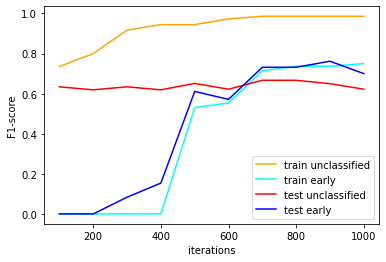

In [53]:
plt.plot(resn6[0],resn6[1],'-',color='orange',ms=10,label='train unclassified') 
plt.plot(resn6[0],resn6[2],'-',color='cyan',ms=10,label='train early') 
plt.plot(resn6[0],resn6[3],'-',color='red',ms=10,label='test unclassified') 
plt.plot(resn6[0],resn6[4],'-',color='blue',ms=10,label='test early') 
plt.legend(loc="best")
plt.xlabel("iterations")
plt.ylabel("F1-score")
#not so good, or just converged? no better should be possible on early (or just overfitting)

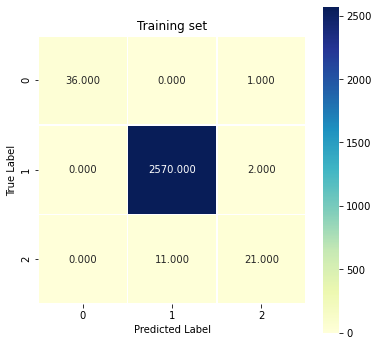

In [54]:

plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrainn1, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

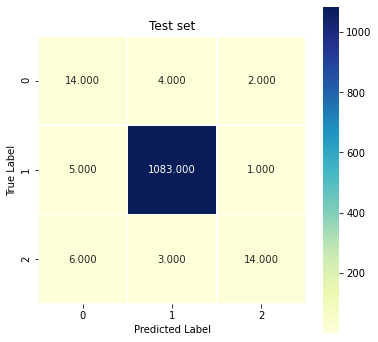

In [55]:

plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtestn1, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

In [ ]:
#two layers maybe, in principle usual for the length
model8 = Sequential(
    [   
        Conv1D(70,16,strides=1, padding="same", activation="relu", name="layer1",input_shape=(141,20),kernel_regularizer=tf.keras.regularizers.L1(0.001)),         
        MaxPooling1D(pool_size=8),
        Conv1D(32,16,strides=1, padding="same", activation="relu", name="layer2",kernel_regularizer=tf.keras.regularizers.L1(0.001)),  
        MaxPooling1D(pool_size=8),        
        Flatten(),        
        Dense(5, activation="relu", name="layer3",kernel_regularizer=tf.keras.regularizers.L1(0.001)),
        Dense(3, activation = "linear")
    ], name = "model8"
) 
